### https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9762926

In [1]:
import json
import random
import os
import pickle
import time
import shutil
import sys
import uuid
from collections import defaultdict
from datetime import timedelta
from glob import glob
from itertools import product
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd

import settings as s
from common import get_weights
from communities import get_communities_spark
from features import generate_features_spark, generate_features_udf_wrapper, SCHEMA_FEAT_UDF

%load_ext autoreload
%autoreload 2

In [2]:
if (
    sys.version_info.major,
    sys.version_info.minor,
    sys.version_info.micro,
) != (3, 11, 8):
    raise EnvironmentError(
        "Only runs efficiently on Python 3.11.8 (Tested on: Conda 24.1.2 | Apple M3 Pro)"
    )

In [3]:
SPARK_CONF = [
    ("spark.driver.memory", "32g"),
    ("spark.worker.memory", "32g"),
    ("spark.driver.maxResultSize", "32g"),
    ("spark.driver.bindAddress", "127.0.0.1"),
    ("spark.sql.execution.arrow.pyspark.enabled", "true"),
    ("spark.network.timeout", "600s"),
    ("spark.sql.autoBroadcastJoinThreshold", -1)
]

shutil.rmtree("artifacts", ignore_errors=True)
spark = (
    SparkSession.builder.appName("testing")
    .config(conf=SparkConf().setAll(SPARK_CONF))
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/24 17:52:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
data = pd.read_csv("./data/Libra_bank_3months_graph/data.csv")
rename = {
    "id_source": "source",
    "id_destination": "target",
    "cum_amount": "amount",
    "nr_transactions": "num_transactions",
    "nr_alerts": "alerts_count",
    "nr_reports": "reports_count",
}

data = data.rename(columns=rename)
data.loc[:, "source_"] = (
    data.loc[:, "source"].astype(str).apply(lambda x: f"nid-{int(x)}")
)
data.loc[:, "target_"] = (
    data.loc[:, "target"].astype(str).apply(lambda x: f"nid-{int(x)}")
)
del data["source"]
del data["target"]
data = data.rename(
    columns={
        "source_": "source",
        "target_": "target",
    }
).loc[:, ["source", "target", "amount", "num_transactions", "alerts_count", "reports_count"]]

In [5]:
nodes_data = pd.DataFrame(index=sorted(set(data["source"].tolist() + data["target"].tolist())))
nodes_data.index.name = "key"

w_alerts = int(data["alerts_count"].sum() * 2)
w_reports = int(data["reports_count"].sum() * 2)

w_alerts_source = data[data["alerts_count"] > 0].groupby("source").agg({"alerts_count": "sum"}).to_dict()["alerts_count"]
w_alerts_target = data[data["alerts_count"] > 0].groupby("target").agg({"alerts_count": "sum"}).to_dict()["alerts_count"]

w_reports_source = data[data["reports_count"] > 0].groupby("source").agg({"reports_count": "sum"}).to_dict()["reports_count"]
w_reports_target = data[data["reports_count"] > 0].groupby("target").agg({"reports_count": "sum"}).to_dict()["reports_count"]

nodes_data.loc[:, "alert_weight"] = nodes_data.index.map(
    lambda x: (w_alerts_source.get(x, 0) + w_alerts_target.get(x, 0)) / w_alerts
)
nodes_data.loc[:, "report_weight"] = nodes_data.index.map(
    lambda x: (w_reports_source.get(x, 0) + w_reports_target.get(x, 0)) / w_reports
)

In [6]:
total_nodes = nodes_data.shape[0]
perc_point_1_cnt = round(total_nodes * (0.1 / 100))
perc_point_2_cnt = round(total_nodes * (0.2 / 100))
perc_point_5_cnt = round(total_nodes * (0.5 / 100))
perc_1_cnt = round(total_nodes * (1 / 100))
perc_10_cnt = round(total_nodes * (10 / 100))
perc_20_cnt = round(total_nodes * (20 / 100))
perc_30_cnt = round(total_nodes * (30 / 100))
perc_40_cnt = round(total_nodes * (40 / 100))
perc_50_cnt = round(total_nodes * (50 / 100))
perc_75_cnt = round(total_nodes * (75 / 100))
print(total_nodes, perc_point_1_cnt, perc_point_2_cnt, perc_point_5_cnt, perc_1_cnt)

385100 385 770 1926 3851


In [7]:
%%time

candidates = nodes_data.index.tolist()
data_in_scope = data.copy(deep=True)
data_in_scope = data_in_scope.set_index(["source", "target"]).join(
    get_weights(data_in_scope).set_index(["source", "target"]), how="left"
).reset_index()
data_in_scope.loc[:, "amount_weighted"] = (
    data_in_scope.loc[:, "amount"] * 
    (data_in_scope.loc[:, "weight"] / data_in_scope.loc[:, "weight"].max())
)

%run model.ipynb

anomalies_main = anomalies.copy(deep=True)

25/07/24 17:52:35 WARN TaskSetManager: Stage 0 contains a task of very large size (3851 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 472,592 | 213,511
Processed hop #2 | 6,730,058 | 194,847
Processed hop #3 | 7,805,533 | 186,398
Processed hop #4 | 8,894,931 | 185,538
Processed hop #5 | 8,889,368 | 185,321

Processing comm_as_target

Processed hop #1 | 414,376 | 221,458
Processed hop #2 | 6,111,806 | 201,104
Processed hop #3 | 7,163,788 | 188,404
Processed hop #4 | 8,469,276 | 186,909
Processed hop #5 | 8,208,835 | 183,360

Processing comm_as_passthrough

Processed hop #1 | 251,417 | 49,869
Processed hop #2 | 1,310,227 | 42,290
Processed hop #3 | 1,725,981 | 40,671
Processed hop #4 | 1,918,895 | 40,412
Processed hop #5 | 1,952,010 | 40,363

Processing comm_as_passthrough_reverse

Processed hop #1 | 197,559 | 49,869
Processed hop #2 | 1,081,845 | 41,267
Processed hop #3 | 1,434,805 | 38,874
Processed hop #4 | 1,719,403 | 38,462
Processed hop #5 | 1,722,034 | 38,030


comm_as_source_features

CPU times: user 37.1 s, sys: 402 ms, total: 37.5 s
Wall time: 37.5 s

comm_as_tar

CPU times: user 1.93 s, sys: 78.9 ms, total: 2.01 s
Wall time: 15.2 s


CPU times: user 4.55 s, sys: 360 ms, total: 4.91 s
Wall time: 38.2 s


CPU times: user 2min 4s, sys: 22.7 s, total: 2min 27s
Wall time: 5min 19s
1-hop-source features creation


25/07/24 18:11:15 WARN TaskSetManager: Stage 12 contains a task of very large size (6867 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.62 s, sys: 259 ms, total: 1.88 s
Wall time: 1min 12s
1-hop-target features creation


25/07/24 18:12:28 WARN TaskSetManager: Stage 15 contains a task of very large size (6961 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.69 s, sys: 237 ms, total: 1.92 s
Wall time: 1min 15s
Features: (385100, 176)
Deleted 10 constant columns
Script executed in 0:21:14
Training the model
CPU times: user 11min 5s, sys: 46.3 s, total: 11min 51s
Wall time: 11min 51s
CPU times: user 25min 9s, sys: 1min 52s, total: 27min 2s
Wall time: 33min 10s


In [8]:
graph_global = ig.Graph.DataFrame(data[["source", "target"]], use_vids=False, directed=True)

In [9]:
def add_predicted_alert_weight(anomalies_input, perc_count_in):
    anomalies_perc_x = anomalies_input.copy(deep=True)
    index = anomalies_perc_x.head(perc_count_in).index.tolist()
    anomalies_perc_x = anomalies_perc_x.loc[index, :]
    anomalies_perc_x.loc[:, "predicted_alert_weight"] = anomalies_perc_x.loc[:, "alert_weight"]
    anomalies_perc_x.loc[:, "predicted_report_weight"] = anomalies_perc_x.loc[:, "report_weight"]
    return anomalies_perc_x

In [10]:
communities_1_hop_dict = dict(communities_1_hop)

comms_1_hop_0_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_1_cnt).index]
comms_1_hop_0_2_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_2_cnt).index]
comms_1_hop_0_5_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_5_cnt).index]
comms_1_hop_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_1_cnt).index]

sizes_1_hop_0_1_perc = [len(x) for x in comms_1_hop_0_1_perc]
sizes_1_hop_0_2_perc = [len(x) for x in comms_1_hop_0_2_perc]
sizes_1_hop_0_5_perc = [len(x) for x in comms_1_hop_0_5_perc]
sizes_1_hop_1_perc = [len(x) for x in comms_1_hop_1_perc]

sizes_edge_1_hop_0_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_1_perc]
sizes_edge_1_hop_0_2_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_2_perc]
sizes_edge_1_hop_0_5_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_5_perc]
sizes_edge_1_hop_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_1_perc]

tpr = np.cumsum(add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_alert_weight"]).values
tpr_report = np.cumsum(add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_report_weight"]).values

results = [{
    "rectify_perc": 1.0,
    "leiden_size_max": np.max(sizes_leiden),
    "leiden_size_mean": np.mean(sizes_leiden),
    "leiden_size_median": np.median(sizes_leiden),
    "1_hop_size_max": np.max(sizes_1_hop),
    "1_hop_size_mean": np.mean(sizes_1_hop),
    "1_hop_size_median": np.median(sizes_1_hop),
    "0.1%": add_predicted_alert_weight(anomalies_main, perc_point_1_cnt)["predicted_alert_weight"].sum(),
    "0.2%": add_predicted_alert_weight(anomalies_main, perc_point_2_cnt)["predicted_alert_weight"].sum(),
    "0.5%": add_predicted_alert_weight(anomalies_main, perc_point_5_cnt)["predicted_alert_weight"].sum(),
    "1%": add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_alert_weight"].sum(),
    "tpr_1%": tpr,
    "tpr_auc_1%": np.mean(tpr),
    "report_0.1%": add_predicted_alert_weight(anomalies_main, perc_point_1_cnt)["predicted_report_weight"].sum(),
    "report_0.2%": add_predicted_alert_weight(anomalies_main, perc_point_2_cnt)["predicted_report_weight"].sum(),
    "report_0.5%": add_predicted_alert_weight(anomalies_main, perc_point_5_cnt)["predicted_report_weight"].sum(),
    "report_1%": add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_report_weight"].sum(),
    "tpr_report_1%": tpr_report,
    "tpr_report_auc_1%": np.mean(tpr_report),
    "max_1_hop_0_1_perc": np.max(sizes_1_hop_0_1_perc),
    "max_1_hop_0_2_perc": np.max(sizes_1_hop_0_2_perc),
    "max_1_hop_0_5_perc": np.max(sizes_1_hop_0_5_perc),
    "max_1_hop_1_perc": np.max(sizes_1_hop_1_perc),
    "mean_1_hop_0_1_perc": np.mean(sizes_1_hop_0_1_perc),
    "mean_1_hop_0_2_perc": np.mean(sizes_1_hop_0_2_perc),
    "mean_1_hop_0_5_perc": np.mean(sizes_1_hop_0_5_perc),
    "mean_1_hop_1_perc": np.mean(sizes_1_hop_1_perc),
    "median_1_hop_0_1_perc": np.median(sizes_1_hop_0_1_perc),
    "median_1_hop_0_2_perc": np.median(sizes_1_hop_0_2_perc),
    "median_1_hop_0_5_perc": np.median(sizes_1_hop_0_5_perc),
    "median_1_hop_1_perc": np.median(sizes_1_hop_1_perc),
    "max_edges_1_hop_0_1_perc": np.max(sizes_edge_1_hop_0_1_perc),
    "max_edges_1_hop_0_2_perc": np.max(sizes_edge_1_hop_0_2_perc),
    "max_edges_1_hop_0_5_perc": np.max(sizes_edge_1_hop_0_5_perc),
    "max_edges_1_hop_1_perc": np.max(sizes_edge_1_hop_1_perc),
    "mean_edges_1_hop_0_1_perc": np.mean(sizes_edge_1_hop_0_1_perc),
    "mean_edges_1_hop_0_2_perc": np.mean(sizes_edge_1_hop_0_2_perc),
    "mean_edges_1_hop_0_5_perc": np.mean(sizes_edge_1_hop_0_5_perc),
    "mean_edges_1_hop_1_perc": np.mean(sizes_edge_1_hop_1_perc),
    "median_edges_1_hop_0_1_perc": np.median(sizes_edge_1_hop_0_1_perc),
    "median_edges_1_hop_0_2_perc": np.median(sizes_edge_1_hop_0_2_perc),
    "median_edges_1_hop_0_5_perc": np.median(sizes_edge_1_hop_0_5_perc),
    "median_edges_1_hop_1_perc": np.median(sizes_edge_1_hop_1_perc),
}]

In [11]:
%%time

anomalies = anomalies_main.copy(deep=True)
for perc in [0.5, 0.5, 0.5]:
    total_nodes = len(anomalies)
    perc_count = round(perc * total_nodes)
    rectify_perc = round(perc_count / len(anomalies_main), 2)
    candidates = add_predicted_alert_weight(anomalies, perc_count).index.tolist()
    filter_ = data["source"].isin(candidates) & data["target"].isin(candidates)
    data_in_scope = data.loc[filter_, :]
    candidates = sorted(set(data_in_scope["source"].unique()).union(data_in_scope["target"].unique()))
    print("=" * 100)
    print(rectify_perc, perc_count, len(candidates), len(anomalies_main), data_in_scope.shape)
    print("=" * 100)
    data_in_scope = data_in_scope.set_index(["source", "target"]).join(
        get_weights(data_in_scope).set_index(["source", "target"]), how="left"
    ).reset_index()
    data_in_scope.loc[:, "amount_weighted"] = data_in_scope.loc[:, "amount"] * data_in_scope.loc[:, "weight"]
    
    %run model.ipynb

    communities_1_hop_dict = dict(communities_1_hop)

    comms_1_hop_0_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_1_cnt).index]
    comms_1_hop_0_2_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_2_cnt).index]
    comms_1_hop_0_5_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_5_cnt).index]
    comms_1_hop_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_1_cnt).index]
    
    sizes_1_hop_0_1_perc = [len(x) for x in comms_1_hop_0_1_perc]
    sizes_1_hop_0_2_perc = [len(x) for x in comms_1_hop_0_2_perc]
    sizes_1_hop_0_5_perc = [len(x) for x in comms_1_hop_0_5_perc]
    sizes_1_hop_1_perc = [len(x) for x in comms_1_hop_1_perc]
    
    sizes_edge_1_hop_0_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_1_perc]
    sizes_edge_1_hop_0_2_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_2_perc]
    sizes_edge_1_hop_0_5_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_5_perc]
    sizes_edge_1_hop_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_1_perc]

    tpr = np.cumsum(add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_alert_weight"]).values
    tpr_report = np.cumsum(add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_report_weight"]).values

    results.append({
        "rectify_perc": rectify_perc,
        "leiden_size_max": np.max(sizes_leiden),
        "leiden_size_mean": np.mean(sizes_leiden),
        "leiden_size_median": np.median(sizes_leiden),
        "1_hop_size_max": np.max(sizes_1_hop),
        "1_hop_size_mean": np.mean(sizes_1_hop),
        "1_hop_size_median": np.median(sizes_1_hop),
        "0.1%": add_predicted_alert_weight(anomalies, perc_point_1_cnt)["predicted_alert_weight"].sum(),
        "0.2%": add_predicted_alert_weight(anomalies, perc_point_2_cnt)["predicted_alert_weight"].sum(),
        "0.5%": add_predicted_alert_weight(anomalies, perc_point_5_cnt)["predicted_alert_weight"].sum(),
        "1%": add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_alert_weight"].sum(),
        "tpr_1%": tpr,
        "tpr_auc_1%": np.mean(tpr),
        "report_0.1%": add_predicted_alert_weight(anomalies, perc_point_1_cnt)["predicted_report_weight"].sum(),
        "report_0.2%": add_predicted_alert_weight(anomalies, perc_point_2_cnt)["predicted_report_weight"].sum(),
        "report_0.5%": add_predicted_alert_weight(anomalies, perc_point_5_cnt)["predicted_report_weight"].sum(),
        "report_1%": add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_report_weight"].sum(),
        "tpr_report_1%": tpr_report,
        "tpr_report_auc_1%": np.mean(tpr_report),
        "max_1_hop_0_1_perc": np.max(sizes_1_hop_0_1_perc),
        "max_1_hop_0_2_perc": np.max(sizes_1_hop_0_2_perc),
        "max_1_hop_0_5_perc": np.max(sizes_1_hop_0_5_perc),
        "max_1_hop_1_perc": np.max(sizes_1_hop_1_perc),
        "mean_1_hop_0_1_perc": np.mean(sizes_1_hop_0_1_perc),
        "mean_1_hop_0_2_perc": np.mean(sizes_1_hop_0_2_perc),
        "mean_1_hop_0_5_perc": np.mean(sizes_1_hop_0_5_perc),
        "mean_1_hop_1_perc": np.mean(sizes_1_hop_1_perc),
        "median_1_hop_0_1_perc": np.median(sizes_1_hop_0_1_perc),
        "median_1_hop_0_2_perc": np.median(sizes_1_hop_0_2_perc),
        "median_1_hop_0_5_perc": np.median(sizes_1_hop_0_5_perc),
        "median_1_hop_1_perc": np.median(sizes_1_hop_1_perc),
        "max_edges_1_hop_0_1_perc": np.max(sizes_edge_1_hop_0_1_perc),
        "max_edges_1_hop_0_2_perc": np.max(sizes_edge_1_hop_0_2_perc),
        "max_edges_1_hop_0_5_perc": np.max(sizes_edge_1_hop_0_5_perc),
        "max_edges_1_hop_1_perc": np.max(sizes_edge_1_hop_1_perc),
        "mean_edges_1_hop_0_1_perc": np.mean(sizes_edge_1_hop_0_1_perc),
        "mean_edges_1_hop_0_2_perc": np.mean(sizes_edge_1_hop_0_2_perc),
        "mean_edges_1_hop_0_5_perc": np.mean(sizes_edge_1_hop_0_5_perc),
        "mean_edges_1_hop_1_perc": np.mean(sizes_edge_1_hop_1_perc),
        "median_edges_1_hop_0_1_perc": np.median(sizes_edge_1_hop_0_1_perc),
        "median_edges_1_hop_0_2_perc": np.median(sizes_edge_1_hop_0_2_perc),
        "median_edges_1_hop_0_5_perc": np.median(sizes_edge_1_hop_0_5_perc),
        "median_edges_1_hop_1_perc": np.median(sizes_edge_1_hop_1_perc),
    })

results = pd.DataFrame(results)
results.to_parquet(f".{os.sep}results{os.sep}rec-ver.parquet")

0.5 192550 190884 385100 (400056, 6)


25/07/24 18:25:42 WARN TaskSetManager: Stage 18 contains a task of very large size (2605 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 312,554 | 106,942
Processed hop #2 | 3,613,160 | 99,089
Processed hop #3 | 4,280,863 | 97,228
Processed hop #4 | 4,679,404 | 96,956
Processed hop #5 | 4,740,996 | 96,907

Processing comm_as_target

Processed hop #1 | 274,397 | 129,029
Processed hop #2 | 4,206,253 | 119,983
Processed hop #3 | 4,856,713 | 116,784
Processed hop #4 | 5,437,022 | 116,272
Processed hop #5 | 5,422,444 | 115,574

Processing comm_as_passthrough

Processed hop #1 | 200,427 | 45,087
Processed hop #2 | 1,218,911 | 40,243
Processed hop #3 | 1,648,108 | 39,290
Processed hop #4 | 1,855,707 | 39,117
Processed hop #5 | 1,897,975 | 39,087

Processing comm_as_passthrough_reverse

Processed hop #1 | 151,417 | 45,087
Processed hop #2 | 970,471 | 39,073
Processed hop #3 | 1,363,137 | 37,431
Processed hop #4 | 1,648,760 | 37,132
Processed hop #5 | 1,690,480 | 36,908


comm_as_source_features

CPU times: user 19.5 s, sys: 182 ms, total: 19.6 s
Wall time: 19.6 s

comm_as_target_fe

CPU times: user 1.46 s, sys: 30.2 ms, total: 1.49 s
Wall time: 7.28 s


CPU times: user 2.17 s, sys: 41 ms, total: 2.22 s
Wall time: 26.1 s


CPU times: user 58.9 s, sys: 1.11 s, total: 60 s
Wall time: 2min 25s
1-hop-source features creation


25/07/24 18:36:15 WARN TaskSetManager: Stage 30 contains a task of very large size (4647 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 930 ms, sys: 155 ms, total: 1.09 s
Wall time: 37.2 s
1-hop-target features creation


25/07/24 18:36:52 WARN TaskSetManager: Stage 33 contains a task of very large size (4688 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.09 s, sys: 144 ms, total: 1.24 s
Wall time: 44.8 s
Features: (190884, 176)
Deleted 10 constant columns
Script executed in 0:11:57
Training the model
CPU times: user 6min 29s, sys: 17.3 s, total: 6min 46s
Wall time: 6min 46s
0.25 95442 95285 385100 (290720, 6)


25/07/24 18:44:28 WARN TaskSetManager: Stage 36 contains a task of very large size (1904 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 251,731 | 66,845
Processed hop #2 | 1,976,232 | 61,492
Processed hop #3 | 2,565,873 | 60,297
Processed hop #4 | 2,867,647 | 60,121
Processed hop #5 | 2,928,053 | 60,083

Processing comm_as_target

Processed hop #1 | 200,701 | 70,230
Processed hop #2 | 1,740,409 | 63,710
Processed hop #3 | 2,290,322 | 61,638
Processed hop #4 | 2,759,204 | 61,269
Processed hop #5 | 2,838,909 | 61,093

Processing comm_as_passthrough

Processed hop #1 | 184,784 | 41,790
Processed hop #2 | 1,146,432 | 38,090
Processed hop #3 | 1,574,709 | 37,419
Processed hop #4 | 1,770,289 | 37,298
Processed hop #5 | 1,811,622 | 37,278

Processing comm_as_passthrough_reverse

Processed hop #1 | 139,460 | 41,790
Processed hop #2 | 904,351 | 36,936
Processed hop #3 | 1,296,612 | 35,702
Processed hop #4 | 1,576,112 | 35,466
Processed hop #5 | 1,630,077 | 35,324


comm_as_source_features

CPU times: user 12 s, sys: 110 ms, total: 12.1 s
Wall time: 12.1 s

comm_as_target_features



CPU times: user 654 ms, sys: 22.2 ms, total: 677 ms
Wall time: 4.92 s


CPU times: user 1.5 s, sys: 28.6 ms, total: 1.53 s
Wall time: 6.29 s


CPU times: user 28.5 s, sys: 248 ms, total: 28.8 s
Wall time: 1min 20s
1-hop-source features creation


25/07/24 18:50:54 WARN TaskSetManager: Stage 48 contains a task of very large size (3398 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 560 ms, sys: 91.6 ms, total: 652 ms
Wall time: 24.7 s
1-hop-target features creation


25/07/24 18:51:18 WARN TaskSetManager: Stage 51 contains a task of very large size (3419 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 590 ms, sys: 95.1 ms, total: 685 ms
Wall time: 24.9 s
Features: (95285, 176)
Deleted 10 constant columns
Script executed in 0:07:17
Training the model
CPU times: user 3min 48s, sys: 5.37 s, total: 3min 54s
Wall time: 3min 54s
0.12 47642 47410 385100 (185446, 6)


25/07/24 18:55:40 WARN TaskSetManager: Stage 54 contains a task of very large size (1223 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 158,584 | 33,237
Processed hop #2 | 1,011,915 | 31,572
Processed hop #3 | 1,359,789 | 31,126
Processed hop #4 | 1,491,716 | 31,072
Processed hop #5 | 1,521,813 | 31,061

Processing comm_as_target

Processed hop #1 | 126,703 | 38,059
Processed hop #2 | 1,097,620 | 35,776
Processed hop #3 | 1,403,375 | 35,077
Processed hop #4 | 1,608,843 | 34,954
Processed hop #5 | 1,662,754 | 34,918

Processing comm_as_passthrough

Processed hop #1 | 126,220 | 23,886
Processed hop #2 | 704,847 | 22,795
Processed hop #3 | 979,070 | 22,540
Processed hop #4 | 1,076,500 | 22,508
Processed hop #5 | 1,099,988 | 22,502

Processing comm_as_passthrough_reverse

Processed hop #1 | 94,455 | 23,886
Processed hop #2 | 552,793 | 22,148
Processed hop #3 | 808,034 | 21,697
Processed hop #4 | 968,496 | 21,612
Processed hop #5 | 1,014,749 | 21,591


comm_as_source_features

CPU times: user 6.31 s, sys: 62.4 ms, total: 6.37 s
Wall time: 6.36 s

comm_as_target_features

CPU ti

CPU times: user 444 ms, sys: 13.4 ms, total: 458 ms
Wall time: 1.67 s


CPU times: user 560 ms, sys: 24.5 ms, total: 585 ms
Wall time: 4.32 s


CPU times: user 14.6 s, sys: 279 ms, total: 14.9 s
Wall time: 41.4 s
1-hop-source features creation


25/07/24 18:59:15 WARN TaskSetManager: Stage 66 contains a task of very large size (2181 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 290 ms, sys: 47.3 ms, total: 338 ms
Wall time: 12.6 s
1-hop-target features creation


25/07/24 18:59:28 WARN TaskSetManager: Stage 69 contains a task of very large size (2189 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 337 ms, sys: 56.9 ms, total: 394 ms
Wall time: 13.6 s
Features: (47410, 176)
Deleted 10 constant columns
Script executed in 0:04:02
Training the model
CPU times: user 2min 33s, sys: 6.15 s, total: 2min 39s
Wall time: 2min 39s
CPU times: user 29min 19s, sys: 1min 18s, total: 30min 38s
Wall time: 36min 41s


<Axes: >

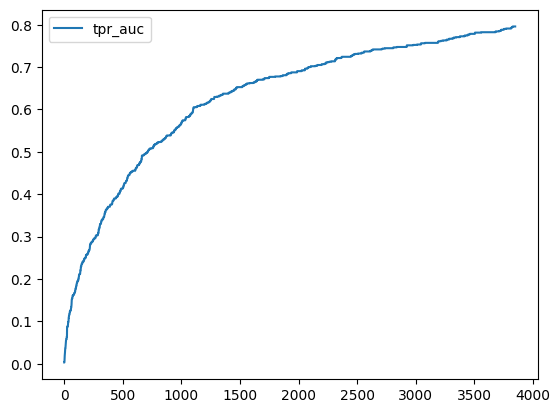

In [13]:
pd.DataFrame(tpr, columns=["tpr_auc"]).plot()